In [3]:
import sys
sys.path.append("../")
import numpy as np
from qiskit import transpile
from qiskit_algorithms.optimizers import SPSA
from sanchez_ansatz import SanchezAnsatz
from experiments.experiment_module import ExperimentModule
from experiments.create_state import get_state
from experiments.densities import compute_eta
from experiments.util import get_state_vector
import matplotlib.pyplot as plt

%matplotlib inline

### Normal distribution

In [74]:
interval = (0, 1) 
num_qubits = 8

scales = [1, 0.6, 0.4, 0.3]

target_states = []
approx_states = []

for scale in scales:

    state_params = {"x_points": interval, "loc": 0.5, "scale": scale}

    normal_amplitudes = get_state(num_qubits, "normal", state_params)
    eta = compute_eta("normal", density_params=state_params)

    sanchez = SanchezAnsatz(normal_amplitudes, eps=0.05, eta=eta)
    init_params = sanchez.init_params
    t_sanchez = transpile(sanchez, basis_gates=["u", "cx"])

    em = ExperimentModule(t_sanchez, SPSA(maxiter=500, learning_rate=1.5, perturbation=0.9), normal_amplitudes, init_params,  device="GPU")

    res = em.minimize()

    t_sanchez = t_sanchez.assign_parameters(res.x)

    result_sv = get_state_vector(t_sanchez)
    
    target_states.append(normal_amplitudes)
    approx_states.append(result_sv)

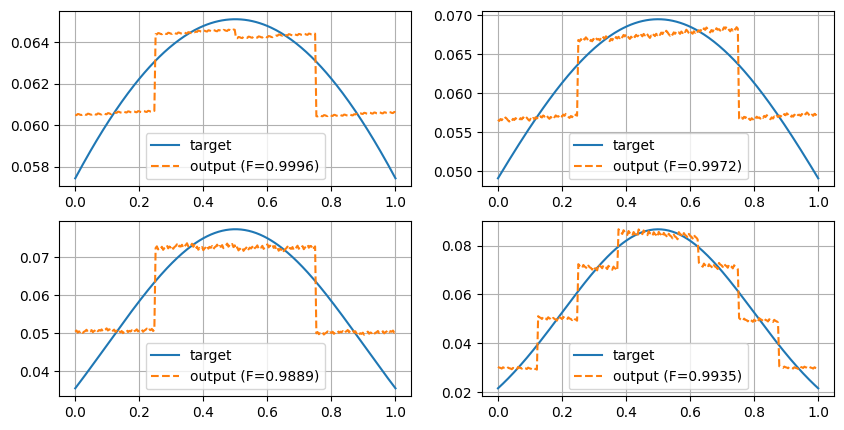

In [75]:
fig, axes = plt.subplots(2, 2, figsize=(10, 5))

x_points = np.linspace(*interval, 2**num_qubits)

axes = axes.reshape(-1)

for (ax, targ_state, approx_state) in zip(axes, target_states, approx_states):
    fid = np.abs(targ_state @ approx_state)**2
    ax.plot(x_points, targ_state, label="target")
    ax.plot(x_points, approx_state, "--", label=f"output (F={np.round(fid, 4)})")
    ax.grid()
    ax.legend(loc="best")

axes = axes.reshape(2, 2)

### Black-Scholes

In [ ]:
interval = (-10, 10)

state_params = {"x_points": interval, "K": 45, "c": 3}

num_qubits = 5
x_points = np.linspace(0, 2**num_qubits, 2**num_qubits)
black_scholes_state = get_state(num_qubits, "black-scholes", state_params)

plt.plot(x_points, black_scholes_state)
plt.show()
